# データの準備

In [36]:
import pandas as pd

# データの読み込み
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [37]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

In [38]:
# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]
# index を振り直す
df_wrime_target = df_wrime_target.reset_index(drop=True)

In [39]:
df_wrime_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sentence                     18237 non-null  object
 1   UserID                       18237 non-null  int64 
 2   Datetime                     18237 non-null  object
 3   Train/Dev/Test               18237 non-null  object
 4   Writer_Joy                   18237 non-null  int64 
 5   Writer_Sadness               18237 non-null  int64 
 6   Writer_Anticipation          18237 non-null  int64 
 7   Writer_Surprise              18237 non-null  int64 
 8   Writer_Anger                 18237 non-null  int64 
 9   Writer_Fear                  18237 non-null  int64 
 10  Writer_Disgust               18237 non-null  int64 
 11  Writer_Trust                 18237 non-null  int64 
 12  Reader1_Joy                  18237 non-null  int64 
 13  Reader1_Sadness              18

In [40]:
# リスト化
sentences = df_wrime_target['Sentence'].tolist()

In [41]:
# 「\n」を「」に置換する
sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# 「x000D」を「」に置換する
sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

# つぶやき分散表現

## モデル

In [42]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 使用するモデルを指定して、トークナイザとモデルを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained("trained_model_deleted_n_3", output_hidden_states=True) # output_hidden_states=Trueで分散表現を取得する

## 分散表現を取得

/nの処理をしなければいけない？

In [43]:
from torch.utils.data import DataLoader

# 入力文章をトークン化する関数
def tokenize(text):
    return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# データローダーを作成する
batch_size = 64
dataloader = DataLoader(sentences, batch_size=batch_size, collate_fn=tokenize)

# モデルをGPUに移動する
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# バッチ処理で分散表現を取得する
embeddings = []
with torch.no_grad():
    for batch in dataloader:
        # バッチをGPUに移動する
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        hidden_states = outputs.hidden_states
        embeddings.append(hidden_states[-1][:, 0]) # 最後の層のCLSトークンのみ取得する

embeddings = torch.cat(embeddings)

# in 1min


In [44]:
# pandasのDataFrameに変換する
df_embeddings = pd.DataFrame(embeddings.tolist())

df_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Columns: 768 entries, 0 to 767
dtypes: float64(768)
memory usage: 106.9 MB


In [45]:
# # 保存する
# df_embeddings.to_csv('embeddings/fine-tuned_embeddings.tsv', sep='\t', index=False)

In [83]:
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.956355,0.032146,0.361482,-0.265137,-0.696939,-0.871904,0.903599,-0.533593,0.490276,-0.970354,...,-0.241054,-1.126215,0.486646,-1.405512,-0.900057,-1.049279,1.167787,-0.075949,0.741892,-0.627046
1,-0.533254,-1.206326,0.074897,-1.410308,-0.549885,1.048042,0.002445,-0.596607,1.100075,-0.153145,...,0.674974,-1.291688,1.776424,-0.260690,-0.259485,-0.955387,-0.312258,0.807128,-0.678947,-0.262757
2,-0.744010,-1.282001,-0.321741,-1.248727,-0.527106,1.306905,0.291521,-0.520591,0.416982,-0.404062,...,0.361023,-0.601789,1.557117,-0.116406,-0.749791,-0.082227,-0.621077,0.988044,-0.847681,-0.502263
3,0.276229,-0.851307,-0.003533,0.464715,-1.167855,0.243708,1.044955,1.635616,0.714853,-0.481880,...,-1.090148,-0.012633,0.080563,0.454924,-1.077015,0.016311,0.838374,0.027606,-1.580882,-0.862648
4,0.125185,-0.989440,-0.381383,-0.686673,-0.758591,2.047386,0.544446,0.337460,0.978610,-0.055610,...,-0.303848,0.094566,1.159924,0.017466,-1.451417,-0.134294,0.165227,1.501274,-1.291980,-0.929152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,-0.678039,-1.038384,0.042022,-1.074588,-0.739475,1.205460,0.744224,0.519175,0.980509,-0.423975,...,-0.389252,0.032871,1.066426,-0.131411,-0.495695,-0.185787,-0.009591,1.104860,-1.463171,-0.885197
18233,-0.363449,-1.192950,-0.033645,-0.917338,-0.976917,0.357919,0.509347,-0.028475,0.869072,-0.869712,...,-0.513671,-0.020581,1.020811,-0.248269,-0.335913,-0.592544,-0.073605,1.153263,-1.047671,-1.305536
18234,-0.855270,-1.462339,-0.026618,-1.193205,-0.591036,1.720993,0.219564,-0.761223,1.052782,0.039549,...,0.295017,-1.105275,1.636999,-0.392450,-0.235305,-1.110773,-0.412585,1.312726,-0.731846,-0.651861
18235,-0.165182,-1.202594,0.212118,-0.359051,-0.970227,0.266728,0.900722,1.030669,0.830413,-1.006975,...,-1.273172,0.141738,0.090361,0.123472,-1.101632,0.186896,0.894079,0.609125,-1.258806,-0.932112


### 正規化してもあまり変わらない

In [94]:
# df_embeddingsの標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_embeddings)
df_embeddings = scaler.transform(df_embeddings)

# pandasのDataFrameに変換する
df_embeddings = pd.DataFrame(df_embeddings)

In [95]:
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.303615,0.376879,0.010993,-0.144749,-0.587939,-2.412277,0.619103,-0.612885,-0.497814,-1.695718,...,-0.007916,-0.234884,-0.776071,-1.796932,-0.647114,-0.447784,0.782336,-1.398971,1.246309,-0.191652
1,-0.629447,-1.010668,-0.586120,-1.261583,-0.318610,0.404160,-1.844295,-0.695256,1.068598,0.163478,...,1.623025,-0.423586,1.390570,0.098729,0.604811,-0.298961,-1.187097,0.447955,-0.514815,0.681103
2,-0.902944,-1.095452,-1.412533,-1.104001,-0.276889,0.783894,-1.054075,-0.595890,-0.686086,-0.407371,...,1.064050,0.363160,1.022166,0.337642,-0.353435,1.085048,-1.598030,0.826333,-0.723960,0.107300
3,0.421018,-0.612915,-0.749533,0.567043,-1.450424,-0.775747,1.005515,2.222630,0.079064,-0.584411,...,-1.519688,1.035021,-1.458231,1.283683,-0.992957,1.241235,0.344001,-1.182389,-1.632760,-0.756104
4,0.225008,-0.767675,-1.536801,-0.555855,-0.700855,1.870133,-0.362680,0.525725,0.756585,0.385377,...,-0.119718,1.157268,0.354938,0.559315,-1.724683,1.002518,-0.551728,1.899736,-1.274667,-0.915432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,-0.817334,-0.822511,-0.654617,-0.934171,-0.665844,0.635082,0.183436,0.763257,0.761465,-0.452675,...,-0.271777,1.086912,0.197876,0.312796,0.143166,0.920899,-0.784351,1.070651,-1.486859,-0.810124
18233,-0.409091,-0.995681,-0.812272,-0.780812,-1.100719,-0.608207,-0.458626,0.047387,0.475212,-1.466751,...,-0.493298,1.025956,0.121249,0.119297,0.455443,0.276166,-0.869532,1.171883,-0.971848,-1.817164
18234,-1.047325,-1.297497,-0.797632,-1.049853,-0.393978,1.391336,-1.250776,-0.910437,0.947115,0.601868,...,0.946530,-0.211005,1.156357,-0.119448,0.652069,-0.545255,-1.320597,1.505396,-0.580384,-0.251105
18235,-0.151800,-1.006486,-0.300215,-0.236339,-1.088467,-0.741978,0.611238,1.431865,0.375907,-1.779032,...,-1.845551,1.211062,-1.441771,0.734845,-1.041068,1.511622,0.418125,0.033837,-1.233549,-0.922522


### 文章間の類似度

In [96]:
from sklearn.metrics.pairwise import cosine_similarity

# target_indexの文章と類似度の高い文章を表示する
target_index = 5935

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

index: 5935
文　章：コナン面白かった！アニオリの中ではここ最近で一番面白いと感じました♪
類似度：0.9999999999999991
---
index: 6037
文　章：またまたいい夢を見た。最高過ぎる♪
類似度：0.956510870003648
---
index: 8774
文　章：お外すずしーー！最高！！
類似度：0.9556815027043819
---
index: 16568
文　章：アイナナライブに行ってきました！\nすごく良かったなあ…！\n仕事で関われて、アイナナに出会えてよかったです(*'ω'*)??大好きな曲いっぱいで盛り上がったわ??
類似度：0.9549151628824691
---
index: 15023
文　章：右折待ちしてたら後ろからクラクションを鳴らされた。なんで安全に運転しようとしてる側がこんなにビクビクしながら生きなきゃいけないんだろうか。\nバックミラーで睨み返したけど、向こうの方が強そうだった。悔しい。わたしはライオンになりたい。
類似度：-0.7178907494875126
---
index: 11125
文　章：年齢重ねるごとに生理がきつくなってる気がする。\n\nなんだろ。これ。\n\n生理いらないわー。\n\nピル試してみようかな。
類似度：-0.716145899141703
---
index: 9500
文　章：売れないミュージシャンみたい。心はミュージシャンでも、一応、途切れず真面目に働いてきた点だけは評価してほしいけれども。いつミュージシャンを諦めて堅気になれるのだろうか。
類似度：-0.7067582844477207
---


---

# クラスタリング

In [97]:
from sklearn.cluster import KMeans

# クラスタリング

# k: クラスター数 (optional)
k = 6

# k-means法の実行
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)
# 各サンプルのクラスター番号を取得する
clusters = kmeansModel.labels_

c:\Users\yossh\anaconda3\envs\bert_env\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


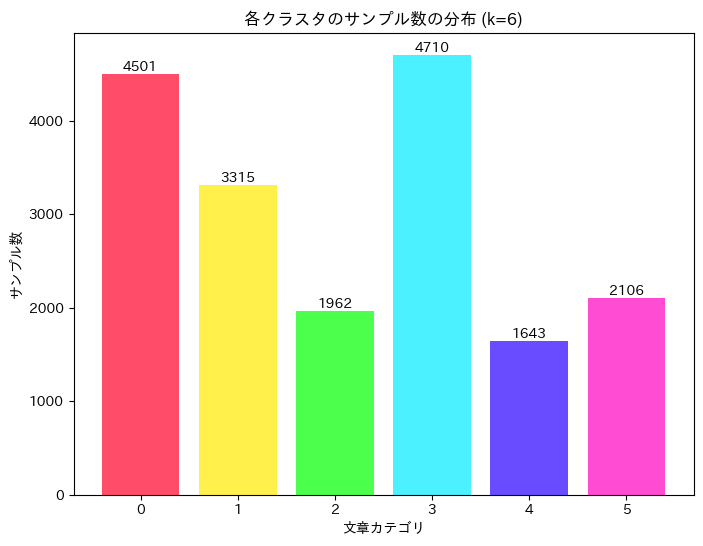

In [98]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# 可視化
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('文章カテゴリ')
plt.ylabel('サンプル数')
plt.title(f'各クラスタのサンプル数の分布 (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## クラスター数の決定

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

In [99]:
'''
# エルボー法による最適クラスター数の調査
SSE = []
for i in range(1, 40):
    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeansModel.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(1, 40), SSE, marker='o', markersize=3)
plt.xlabel('クラスター数')
plt.ylabel('SSE')
plt.title('エルボー法による最適クラスター数の調査')
plt.show()
'''

"\n# エルボー法による最適クラスター数の調査\nSSE = []\nfor i in range(1, 40):\n    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    SSE.append(kmeansModel.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(1, 40), SSE, marker='o', markersize=3)\nplt.xlabel('クラスター数')\nplt.ylabel('SSE')\nplt.title('エルボー法による最適クラスター数の調査')\nplt.show()\n"

<img src="figures/fine-tuned_elbow.png">

### シルエット係数による最適クラスター数の調査

In [100]:
'''
from sklearn.metrics import silhouette_score

# シルエット係数による最適クラスター数の調査
silhouette_coefficients = []
for i in range(2, 40):
    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeansModel.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, 40), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('クラスター数')
plt.ylabel('シルエット係数の平均値')
plt.title('シルエット係数の平均値による最適クラスター数の調査')
plt.show()
'''

"\nfrom sklearn.metrics import silhouette_score\n\n# シルエット係数による最適クラスター数の調査\nsilhouette_coefficients = []\nfor i in range(2, 40):\n    kmeansModel = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    silhouette_coefficient = silhouette_score(df_embeddings, kmeansModel.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, 40), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('クラスター数')\nplt.ylabel('シルエット係数の平均値')\nplt.title('シルエット係数の平均値による最適クラスター数の調査')\nplt.show()\n"

<img src = "figures/fine-tuned_silhouette.png">

### シルエット図

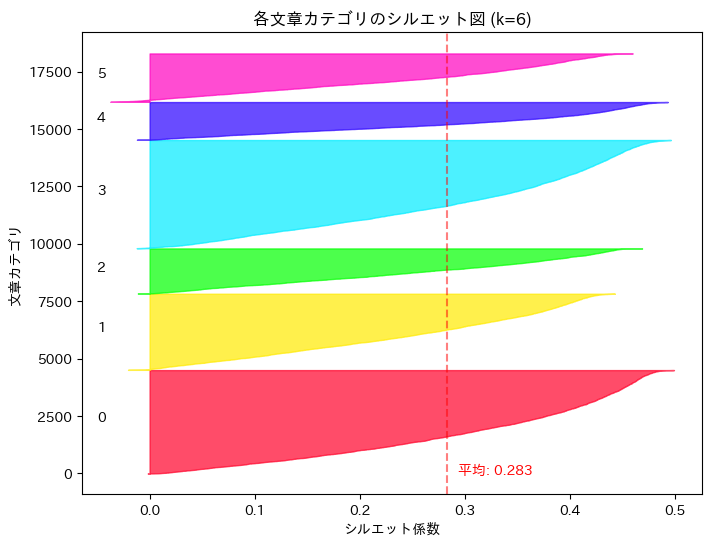

In [101]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"平均: {silhouette_avg:.3f}", color="red")

plt.xlabel('シルエット係数')
plt.ylabel('文章カテゴリ')
plt.title(f'各文章カテゴリのシルエット図 (k={k})')
plt.show()

In [102]:
# 各文章カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'文章のindex: {index}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

文章カテゴリ: 0
シルエット係数が最も高い文章: 去年食べたホットエアーさんのラーメン食べたいなあ。開いていたら、思い切って食べに行っちゃおうかなあ。
文章のindex: 1727
シルエット係数: 0.499
---
文章カテゴリ: 1
シルエット係数が最も高い文章: 好きだった親友を苦手になってしまった\nそんなことばっかりで友人が減る\n悲しい
文章のindex: 16370
シルエット係数: 0.443
---
文章カテゴリ: 2
シルエット係数が最も高い文章: 薄い緑色のフィルター灰色になるほどホコリ溜まってたしな?。元々薬剤かけておけば清潔教の父上なので「やった」ってことで大丈夫と思っちゃってんだろうなぁ。。年寄りの部屋はノンストップでエアコンつけてる時期だから気をつけないと病気になりそうで怖いね。
文章のindex: 17386
シルエット係数: 0.469
---
文章カテゴリ: 3
シルエット係数が最も高い文章: ベイブ見た、相変わらず豚可愛い
文章のindex: 13904
シルエット係数: 0.496
---
文章カテゴリ: 4
シルエット係数が最も高い文章: 一発あたり?今日来てるかも?でもとなりの男子中学生うぜ?座らなかったから座ったら「お前が早く座れば?」で揉め始めてうざい。あとなんでこの時間に乗ってるんだ？遅刻か？なんか集合なのか？とにかくうざい。となりのお前、そわそわしすぎ。大人しくしてくれ。
文章のindex: 2502
シルエット係数: 0.493
---
文章カテゴリ: 5
シルエット係数が最も高い文章: 車のブレーキランプがハート型のやつ、初めて見た。ビックリ！！！
文章のindex: 5626
シルエット係数: 0.460
---


In [139]:
# 喜びカテゴリ(0)と一致するクラスタの文章ベクトルと悲しみカテゴリ(1)と一致するクラスタの文章ベクトルの平均を計算
mean_vector = (df_embeddings.iloc[13904, :] + df_embeddings.iloc[16370, :]) / 2
# pandasのDataFrameに変換
df_mean_vector = pd.DataFrame(mean_vector).T

df_wrime_target['similarity'] = cosine_similarity(df_mean_vector, df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(6)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

index: 647
文　章：これは愛知可哀想すぎて 
類似度：0.6747495767871203
---
index: 4563
文　章：イオン銀行の預金金利下がるのか～1番良かっただけに残念
類似度：0.666420503923069
---
index: 11871
文　章：自分がパンになる夢見た イースト菌足りなくてふくらまなかった おじさんに怒られた かなしい
類似度：0.6645604197121061
---
index: 16119
文　章：あ、お昼寝天彦先生終わってた･･･残念←
類似度：0.6626409165814905
---
index: 11340
文　章：予約までして借りた鹿の王結局読めずに返しました悲しい
類似度：0.6597748621970373
---
index: 7464
文　章：なあちゃん卒業ライブみんなで見てガチ泣きしてしまった。
類似度：0.6597257922586792
---


In [120]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 4
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    print('---')

文章カテゴリ: 4
シルエット係数が高い文章: 一発あたり?今日来てるかも?でもとなりの男子中学生うぜ?座らなかったから座ったら「お前が早く座れば?」で揉め始めてうざい。あとなんでこの時間に乗ってるんだ？遅刻か？なんか集合なのか？とにかくうざい。となりのお前、そわそわしすぎ。大人しくしてくれ。
シルエット係数: 0.493
---
文章カテゴリ: 4
シルエット係数が高い文章: まじで後輩、むり。\n2年目で使いもんにならんとかなんなん。\n結構偉い人へ渡す書類の偉い人の名前間違えたまま渡しちゃうし。\n確認不足すぎやろ。\n何で名前間違うねん！\nその謝罪も自分でせえへんとか、まじでキレそう。\nお前の失敗やんけ。
シルエット係数: 0.491
---
文章カテゴリ: 4
シルエット係数が高い文章: エレベーター降りるからすいませんつってんのに無視して微動打にしないオヤジもバカなの？死ぬの？
シルエット係数: 0.490
---
文章カテゴリ: 4
シルエット係数が高い文章: 引っ越した時にマイナンバーカードの電子証明書っていうのが失効してて再申請しないといけないらしい。自動で切り替わるようにしとけよ、まじで使えないカードだな・・・　しかも申請は窓口まで行かないとダメとかクソ過ぎる。
シルエット係数: 0.490
---
文章カテゴリ: 4
シルエット係数が高い文章: これから殆ど家にいる日ばかりなのに、起きてすぐテレビつけんなよ。\n1日何時間付けてる気だよ。\n用も無いのにテレビつけてるなんて馬鹿の極みだろ。\n1円でも電気代節約しろよ。
シルエット係数: 0.489
---


## クラスタリング結果の可視化

### PCA

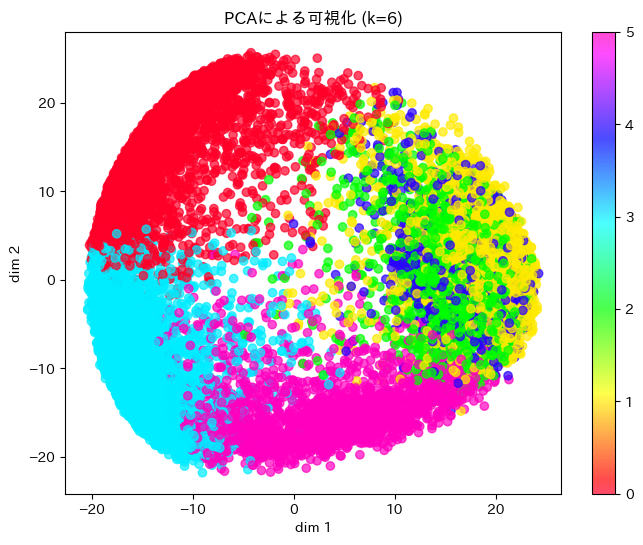

In [121]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_embeddings)
df_embeddings_pca = pca.transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_embeddings_pca[:, 0], df_embeddings_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCAによる可視化 (k={k})')
plt.colorbar()
plt.show()

### t-SNE

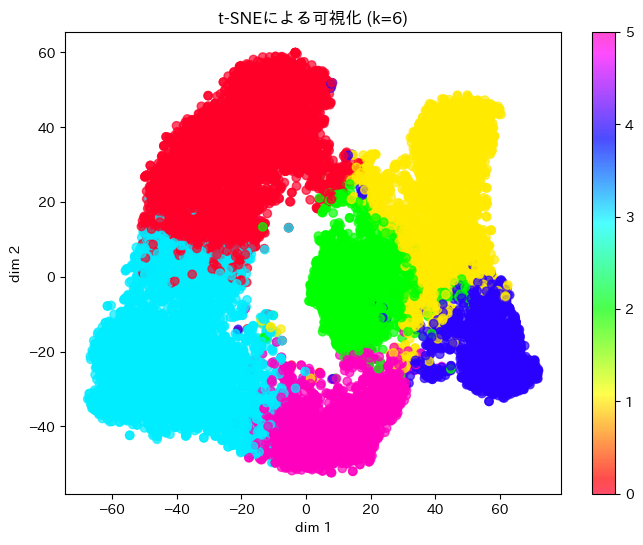

In [122]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNEによる可視化 (k={k})')
plt.colorbar()
plt.show()

# in 1min

### UMAP

In [123]:
'''
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0)
df_wrime_features_umap = umap_obj.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAPによる可視化 (k={k})')
plt.colorbar()
plt.show()
'''

"\nimport umap\n\n# UMAP\numap_obj = umap.UMAP(n_components=2, random_state=0)\ndf_wrime_features_umap = umap_obj.fit_transform(df_embeddings)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\nplt.title(f'UMAPによる可視化 (k={k})')\nplt.colorbar()\nplt.show()\n"

---

# 感情カテゴリとつぶやき分散表現の関係

In [124]:
# clusters/emotion_6clusters.tsvを読み込み
df_clusters = pd.read_csv('clusters/emotion_6clusters.tsv', sep='\t', header=None)
# 変換
emotion_clusters = df_clusters[0].tolist()
emotion_clusters = [int(x) for x in emotion_clusters]
df_emotion_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])

In [125]:
df_emotion_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


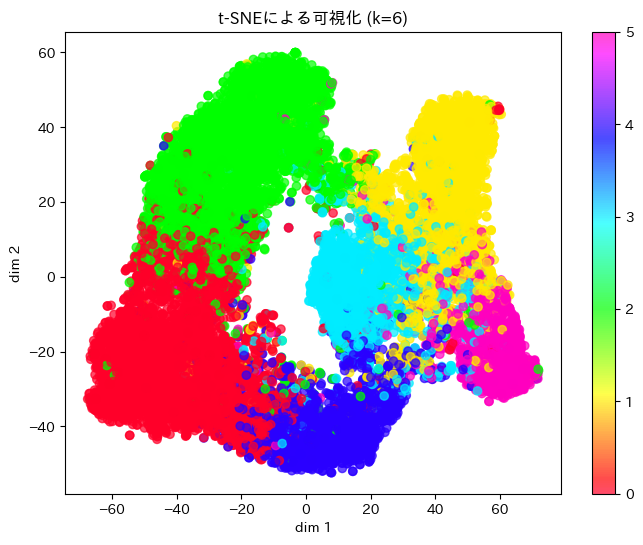

In [126]:
# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNEによる可視化 (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

---

### 感情カテゴリを正解ラベルとして、つぶやき分散表現から学習

In [127]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_emotion_clusters], ignore_index=True, axis=1)
df_embeddings_clusters


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,1.303615,0.376879,0.010993,-0.144749,-0.587939,-2.412277,0.619103,-0.612885,-0.497814,...,-0.234884,-0.776071,-1.796932,-0.647114,-0.447784,0.782336,-1.398971,1.246309,-0.191652,1
1,train,-0.629447,-1.010668,-0.586120,-1.261583,-0.318610,0.404160,-1.844295,-0.695256,1.068598,...,-0.423586,1.390570,0.098729,0.604811,-0.298961,-1.187097,0.447955,-0.514815,0.681103,4
2,train,-0.902944,-1.095452,-1.412533,-1.104001,-0.276889,0.783894,-1.054075,-0.595890,-0.686086,...,0.363160,1.022166,0.337642,-0.353435,1.085048,-1.598030,0.826333,-0.723960,0.107300,0
3,train,0.421018,-0.612915,-0.749533,0.567043,-1.450424,-0.775747,1.005515,2.222630,0.079064,...,1.035021,-1.458231,1.283683,-0.992957,1.241235,0.344001,-1.182389,-1.632760,-0.756104,2
4,train,0.225008,-0.767675,-1.536801,-0.555855,-0.700855,1.870133,-0.362680,0.525725,0.756585,...,1.157268,0.354938,0.559315,-1.724683,1.002518,-0.551728,1.899736,-1.274667,-0.915432,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,-0.817334,-0.822511,-0.654617,-0.934171,-0.665844,0.635082,0.183436,0.763257,0.761465,...,1.086912,0.197876,0.312796,0.143166,0.920899,-0.784351,1.070651,-1.486859,-0.810124,0
18233,train,-0.409091,-0.995681,-0.812272,-0.780812,-1.100719,-0.608207,-0.458626,0.047387,0.475212,...,1.025956,0.121249,0.119297,0.455443,0.276166,-0.869532,1.171883,-0.971848,-1.817164,2
18234,train,-1.047325,-1.297497,-0.797632,-1.049853,-0.393978,1.391336,-1.250776,-0.910437,0.947115,...,-0.211005,1.156357,-0.119448,0.652069,-0.545255,-1.320597,1.505396,-0.580384,-0.251105,0
18235,train,-0.151800,-1.006486,-0.300215,-0.236339,-1.088467,-0.741978,0.611238,1.431865,0.375907,...,1.211062,-1.441771,0.734845,-1.041068,1.511622,0.418125,0.033837,-1.233549,-0.922522,2


In [128]:
# train / test に分割する
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [129]:
import xgboost as xgb

# xgboostの入力データを作成
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.60158	test-mlogloss:1.63450
[1]	train-mlogloss:1.45263	test-mlogloss:1.50959
[2]	train-mlogloss:1.33022	test-mlogloss:1.40994
[3]	train-mlogloss:1.22657	test-mlogloss:1.32797
[4]	train-mlogloss:1.13702	test-mlogloss:1.25378
[5]	train-mlogloss:1.05934	test-mlogloss:1.19228
[6]	train-mlogloss:0.99076	test-mlogloss:1.13709
[7]	train-mlogloss:0.92999	test-mlogloss:1.08788
[8]	train-mlogloss:0.87607	test-mlogloss:1.04591
[9]	train-mlogloss:0.82778	test-mlogloss:1.00791
[10]	train-mlogloss:0.78431	test-mlogloss:0.97394
[11]	train-mlogloss:0.74506	test-mlogloss:0.94358
[12]	train-mlogloss:0.70957	test-mlogloss:0.91713
[13]	train-mlogloss:0.67744	test-mlogloss:0.89262
[14]	train-mlogloss:0.64817	test-mlogloss:0.87018
[15]	train-mlogloss:0.62151	test-mlogloss:0.85097
[16]	train-mlogloss:0.59710	test-mlogloss:0.83349
[17]	train-mlogloss:0.57482	test-mlogloss:0.81834
[18]	train-mlogloss:0.55445	test-mlogloss:0.80402
[19]	train-mlogloss:0.53574	test-mlogloss:0.79242
[20]	train

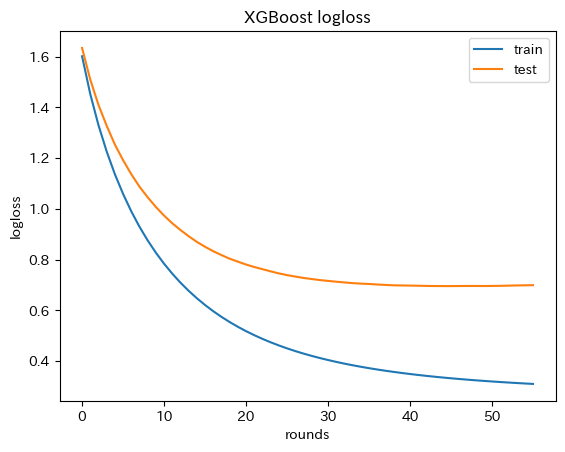

In [130]:
# モデル
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.1,
}

history = dict()

# 学習
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=10)

# 予測
preds_labels = model.predict(test_data)

# グラフ描写
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

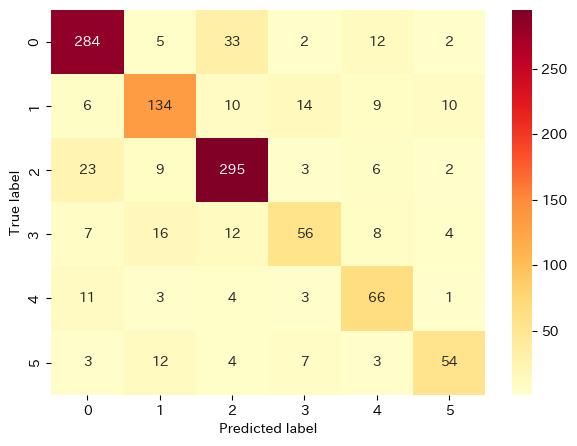

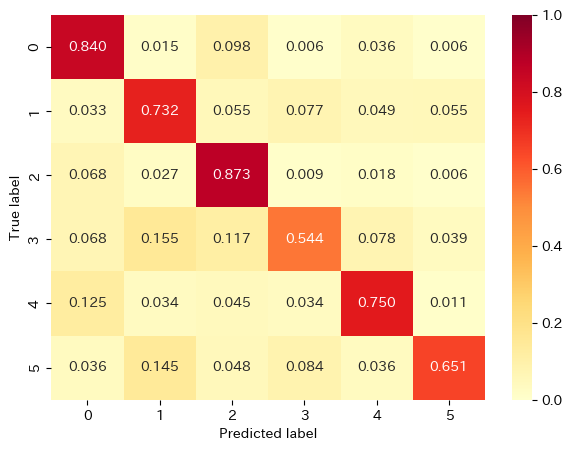

              precision    recall  f1-score   support

           0      0.850     0.840     0.845       338
           1      0.749     0.732     0.740       183
           2      0.824     0.873     0.848       338
           3      0.659     0.544     0.596       103
           4      0.635     0.750     0.688        88
           5      0.740     0.651     0.692        83

    accuracy                          0.785      1133
   macro avg      0.743     0.732     0.735      1133
weighted avg      0.784     0.785     0.783      1133



In [131]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

In [132]:
# 間違って予測された文章のindexを取得
wrong_preds = np.where(test_labels != preds_labels)[0]

# 間違って予測された文章を5個表示
for i in wrong_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

はんばーぐたべたい。
True label: 3
Predicted label: 4.0
---
焼き肉いきたい。
True label: 1
Predicted label: 3.0
---
忙しくて体痛いし眠いしゲームする余裕がない
True label: 1
Predicted label: 5.0
---
仕事納め!がんばろ！
True label: 2
Predicted label: 1.0
---
よっしゃ～終わった！お腹すいた～！
True label: 0
Predicted label: 2.0
---


---

### fine-tuned bertのクラスターと感情カテゴリの一致度

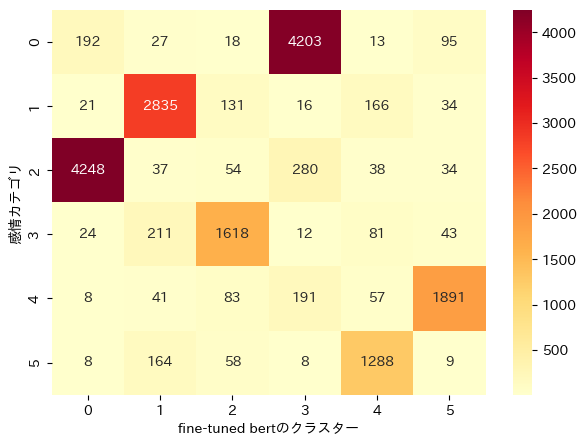

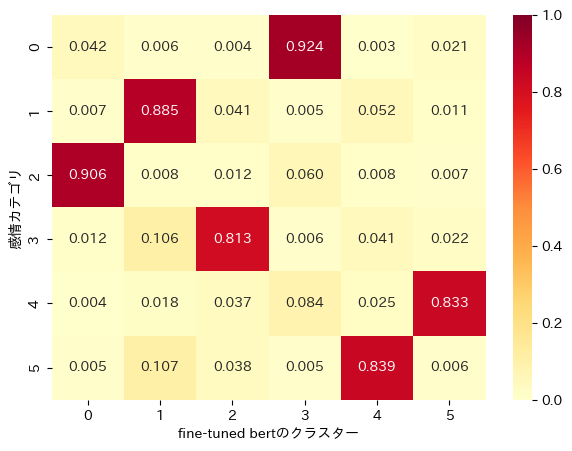

In [133]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])

# fine-tunedのクラスタリングとemotionのクラスタリングの比較
cm = confusion_matrix(df_emotion_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('fine-tuned bertのクラスター')
plt.ylabel('感情カテゴリ')
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('fine-tuned bertのクラスター')
plt.ylabel('感情カテゴリ')
plt.show()